In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import griddata

C:\Users\20211860\AppData\Local\Temp\ipykernel_22704\2751284007.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [29]:
# Choose elevation and azimuth angles
elev = 45
azim = 45

# Choose data

In [22]:
def process_data(mpc_df, nn_df, output_file):
    difference = mpc_df.iloc[:, 5] - nn_df.iloc[:, 5]
    
    # Calculate constraint violations for NN predictions
    upper_violations = np.maximum(nn_df.iloc[:, 5] - 20, 0)
    lower_violations = np.maximum(-nn_df.iloc[:, 5], 0)
    
    max_violation = np.maximum(upper_violations, lower_violations).max()
    max_violation_index = np.maximum(upper_violations, lower_violations).idxmax()
    
    result = pd.DataFrame({
        'MPC': mpc_df.iloc[:, 5],
        'NN': nn_df.iloc[:, 5],
        'Difference': difference,
        'Upper Constraint Violation': upper_violations,
        'Lower Constraint Violation': lower_violations
    })
    result.to_csv(output_file, index=False)
    
    max_difference = difference.max()
    max_difference_index = difference.idxmax()
    
    return difference.mean(), max_difference, result.loc[max_difference_index], max_violation, result.loc[max_violation_index]

# Read CSV files into DataFrames
data_files = [pd.read_csv(file) for file in file_paths]

# Process the data for each prediction horizon
results = [
    # process_data(data_files[0], data_files[1], 'Mesh_Data/Difference_PH2_FINE.csv'),
]

# Prepare data for DataFrame
avg_diff_data = {
    'Prediction Horizon': ['2', '2F', '2F2', '10', '10F', '10F2'],
    'Average Difference': [res[0] for res in results],
    'Maximum Difference': [res[1] for res in results],
    'Maximum Difference Row': [res[2] for res in results],
    'Maximum Constraint Violation': [res[3] for res in results],
    'Maximum Constraint Violation Row': [res[4] for res in results],
}

average_diff_df = pd.DataFrame(avg_diff_data)
display(average_diff_df)


,Prediction Horizon,Maximum Constraint Violation
0,2,0.705137
1,2F,0.304547
2,2F2,0.262054
3,10,0.742521
4,10F,0.307997
5,10F2,0.153744


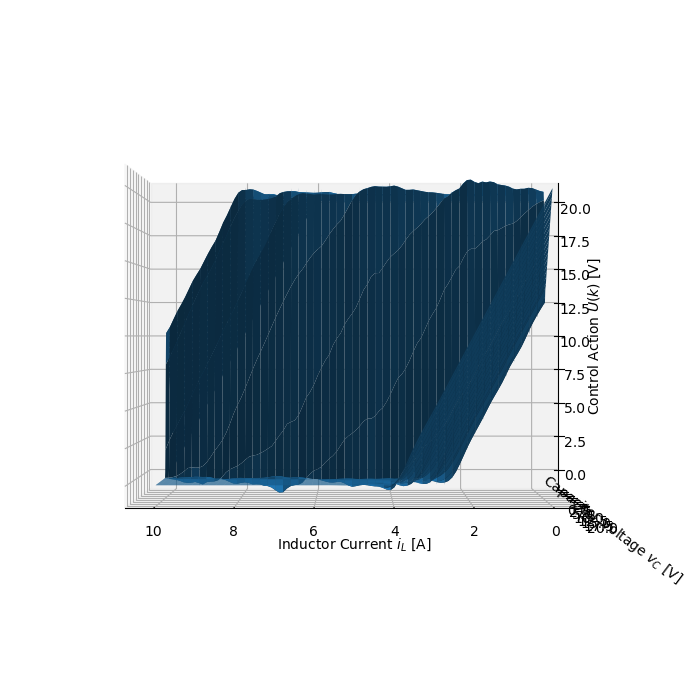

In [146]:
def plot_3d_mesh(ax, data, title, elev, azim):
    X = data.iloc[:, 0]
    Y = data.iloc[:, 1]
    Z = data.iloc[:, 5]

    xi = np.linspace(X.min(), X.max(), 100)
    yi = np.linspace(Y.min(), Y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)
    
    zi = griddata((X, Y), Z, (xi, yi), method='cubic')

    surf = ax.plot_surface(xi, yi, zi, edgecolor='none')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel(r'Inductor Current $i_L$ [A]')
    ax.set_ylabel(r'Capacitor Voltage $v_C$ [V]')
    ax.set_zlabel(r'Control Action $U(k)$ [V]')
    ax.set_title(title)
    
    return surf

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(111, projection='3d')  # Use only one subplot for simplicity

plot_3d_mesh(ax1, data_PH10_MPC, '', elev, azim)

plt.tight_layout()
# plt.savefig('Mesh.svg', format='svg', dpi=300, bbox_inches='tight', pad_inches=0.3)  # Increased pad_inches

plt.show()